# Logistic Regression with a Neural Network mindset

In [145]:
import numpy as np
import h5py
    
    
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline

2 - Overview of the Problem set¶
Problem Statement: You are given a dataset ("data.h5") containing:

- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [147]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


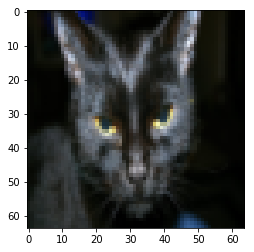

In [148]:

# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

Exercise: Find the values for:

- m_train (number of training examples)
- m_test (number of test examples)
- num_px (= height = width of a training image)
Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access m_train by writing train_set_x_orig.shape[0].

In [149]:
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]

train_set_flat=train_set_x_orig.reshape(num_px*num_px*3,m_train)

test_set_flat=test_set_x_orig.reshape(num_px*num_px*3,m_test)

In [151]:
train_set_flat = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_flat = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [152]:
train_set_flat=train_set_flat/255
test_set_flat=test_set_flat/255

In [153]:
train_set_flat.shape[0]

12288

In [154]:
def sigmoid(z):
    return(1/(1+np.exp(-z)))

In [155]:
sigmoid(9.2)

0.99989897080609225

In [156]:
def initialize_with_zeros(dim):
    w=np.zeros(dim).reshape(dim,1)
    b=0
    return w,b

In [157]:
initialize_with_zeros(7)

(array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]), 0)

In [158]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    m=X.shape[1]
    z=np.dot(w.T,X)+b
    a=sigmoid(z)
    cost=(-1/m)*np.sum(Y*np.log(a)+(1-Y)*np.log(1-a))
    dz=a-Y
    dw=(1/m)*np.dot(X,dz.T)
    db=(1/m)*np.sum(dz)
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost,dw,db

In [159]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
print(propagate(w, b, X, Y))

(6.0000647731922054, array([[ 0.99993216],
       [ 1.99980262]]), 0.49993523062470574)


In [160]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs=[]
    
    for i in range(1,num_iterations+1):
        cost,dw,db=propagate(w, b, X, Y)
        costs.append(cost)
        w=w-learning_rate*dw
        b=b-learning_rate*db
        if print_cost and i%100==0:
            print(cost)
    params={'w':w,'b':b}
    grads={'dw':dw,'db':db}
    return params,grads,costs

In [161]:
params,grads,cost=optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

In [162]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    z=np.dot(w.T,X)+b
    a=sigmoid(z)
    Y_prediction=np.where(a>=0.5,1,0)
    return Y_prediction

In [163]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1 1]]


In [164]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w,b=initialize_with_zeros(X_train.shape[0])
    params,grads,cost=optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w=params['w']
    b=params['b']
    Y_test_predicted=predict(w,b,X_test)
    accuracy=100 - np.mean(np.abs(Y_test_predicted - Y_test)) * 100
    d={'params':params,'grads':grads,'costs':cost,'test_accuracy':accuracy}
    return d
    

In [167]:
d = model(train_set_flat, train_set_y, test_set_flat, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

0.644897882953
0.484893614148
0.377761495216
0.331775405552
0.303528672026
0.28009427758
0.260225847563
0.243100183998
0.228144327695
0.214943770697
0.203189282191
0.192644280204
0.183123891531
0.174481013869
0.16659675354
0.159373695099
0.152731058499
0.146601146299
0.14092669167
0.135658847439


In [168]:
d['test_accuracy']

70.0

In [193]:
def categorize_image(filename):
    ## START CODE HERE ## (PUT YOUR IMAGE NAME) 
    my_image = filename   # change this to the name of your image file 
    ## END CODE HERE ##

    # We preprocess the image to fit your algorithm.
    fname =  my_image
    image = np.array(ndimage.imread(fname, flatten=False))
    my_image = scipy.misc.imresize(image, size=(num_px, num_px)).reshape((1, num_px * num_px * 3)).T
    my_predicted_image = predict(d['params']["w"], d['params']["b"], my_image)

    plt.imshow(image)
    print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 0, your algorithm predicts a "non-cat" picture.


C:\Users\iGuest\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


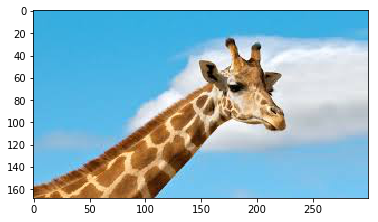

In [194]:
categorize_image('giraffe.jpg')

y = 1, your algorithm predicts a "cat" picture.


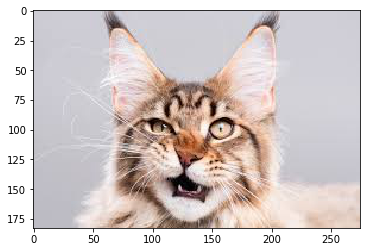

In [195]:
categorize_image('cat.jpg')

y = 0, your algorithm predicts a "non-cat" picture.


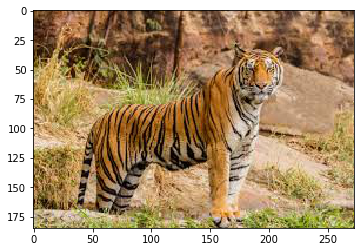

In [196]:
categorize_image('tiger.jpg')

y = 0, your algorithm predicts a "non-cat" picture.


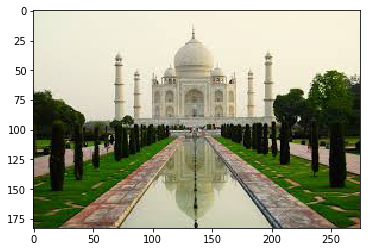

In [197]:
categorize_image('my_image.jpg')